In [32]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
base_path = os.path.join('', 'input')
#train_h5_path = os.path.join(base_path, 'food_c101_n10099_r32x32x1.h5')
#test_h5_path = os.path.join(base_path, 'food_test_c101_n1000_r32x32x1.h5')
train_h5_path = os.path.join(base_path, 'food_c101_n10099_r64x64x3.h5')
test_h5_path = os.path.join(base_path, 'food_test_c101_n1000_r64x64x3.h5')
%matplotlib inline


In [33]:
X_train = HDF5Matrix(train_h5_path, 'images')
y_train = HDF5Matrix(train_h5_path, 'category')
print('In Data',X_train.shape,'=>', y_train.shape)

In Data (10099, 64, 64, 3) => (10099, 101)


In [34]:
X_test = HDF5Matrix(test_h5_path, 'images')
y_test = HDF5Matrix(test_h5_path, 'category')
print('In Data',X_test.shape,'=>', y_test.shape)

In Data (1000, 64, 64, 3) => (1000, 101)


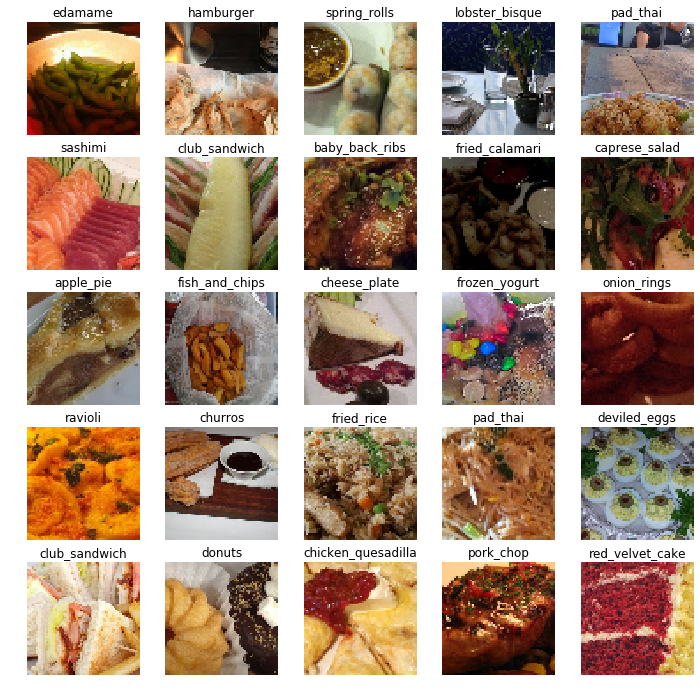

In [35]:

sample_imgs = 25
with h5py.File(train_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    #c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = "gray")
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0])
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])

In [36]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_test.shape[1]))
model.add(Activation('softmax'))
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

loss_history = []
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)        18496     
__________

In [37]:
#for i in range(10):
for i in range(5):
    loss_history += [model.fit(X_train, y_train,
                               validation_data=(X_test, y_test), 
                               batch_size = 256,
                               epochs = 2, shuffle="batch")]

Train on 10099 samples, validate on 1000 samples
Epoch 1/2
10099/10099 [==============================] - 370s 37ms/step - loss: 15.9408 - acc: 0.0102 - val_loss: 15.9730 - val_acc: 0.0090
Epoch 2/2
10099/10099 [==============================] - 2515s 249ms/step - loss: 15.9573 - acc: 0.0098 - val_loss: 15.9730 - val_acc: 0.0090
Train on 10099 samples, validate on 1000 samples
Epoch 1/2
10099/10099 [==============================] - 405s 40ms/step - loss: 15.9404 - acc: 0.0107 - val_loss: 15.9730 - val_acc: 0.0090
Epoch 2/2
10099/10099 [==============================] - 394s 39ms/step - loss: 15.9441 - acc: 0.0098 - val_loss: 16.0536 - val_acc: 0.0040
Train on 10099 samples, validate on 1000 samples
Epoch 1/2
10099/10099 [==============================] - 432s 43ms/step - loss: 15.9520 - acc: 0.0102 - val_loss: 16.0536 - val_acc: 0.0040
Epoch 2/2
10099/10099 [==============================] - 410s 41ms/step - loss: 15.9490 - acc: 0.0105 - val_loss: 16.0536 - val_acc: 0.0040
Train on 10

Text(0.5, 1.0, 'Accuracy')

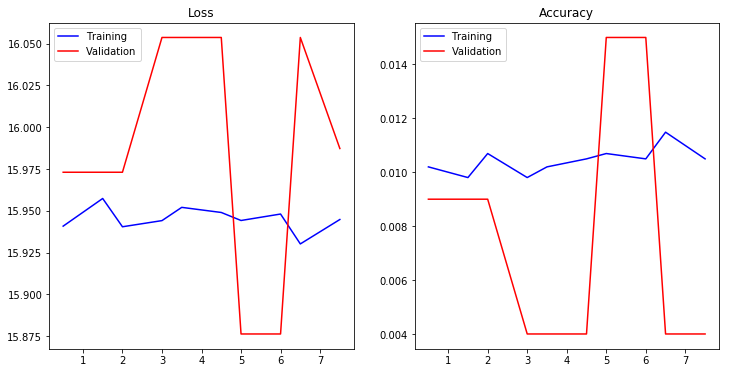

In [38]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['acc'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_acc'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')

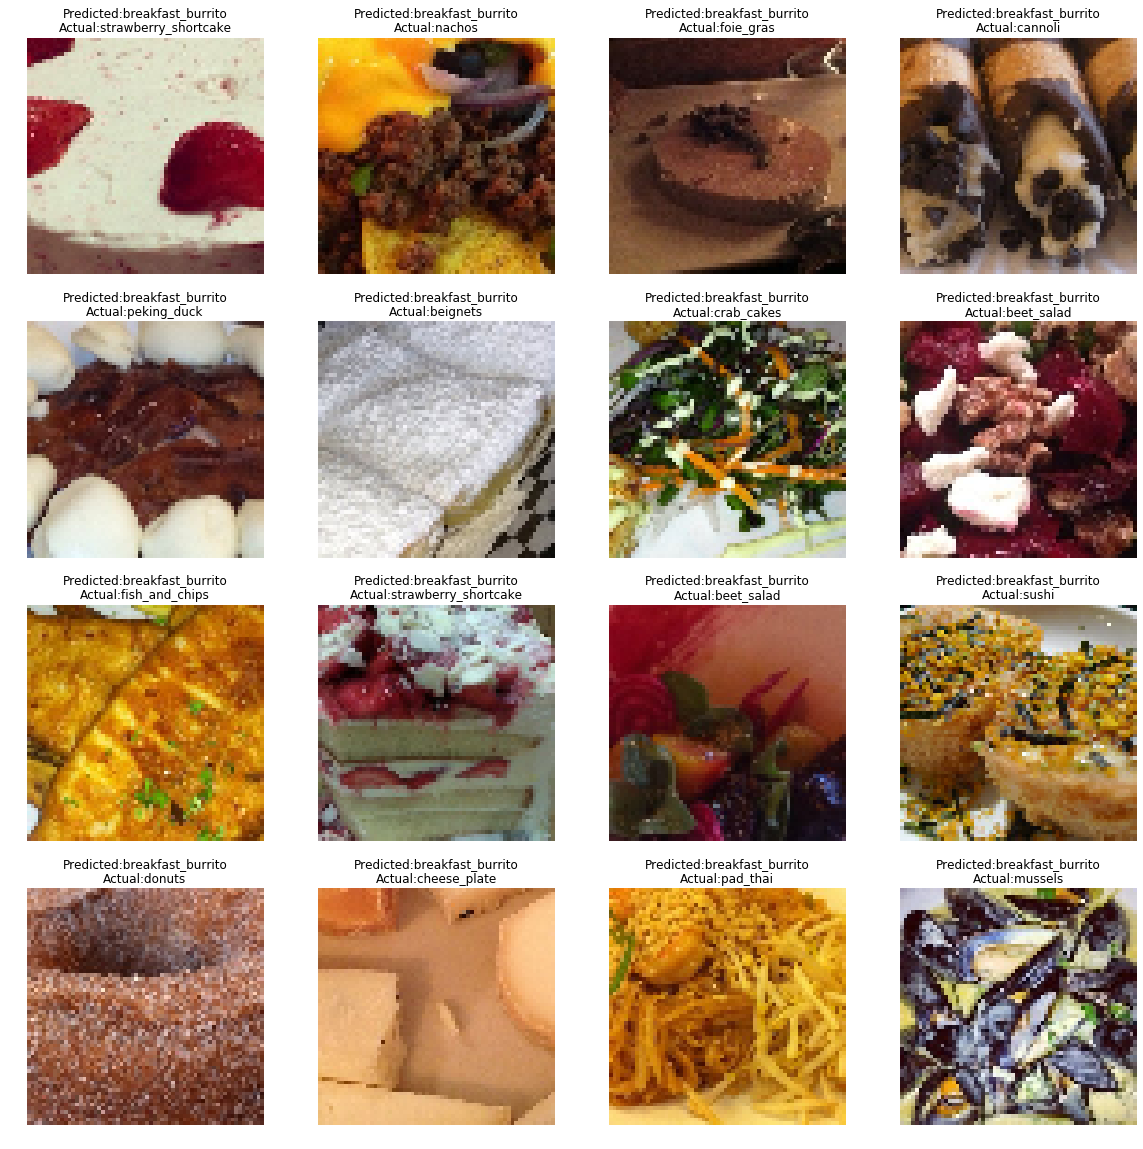

In [43]:
sample_imgs = 16
with h5py.File(test_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
pred_label = model.predict(im_data)
fig, m_ax = plt.subplots(4, 4, figsize = (20, 20))
#fig, m_ax = plt.subplots(4, 4, figsize = (64, 64))
for c_ax, c_label, c_pred, c_img in zip(m_ax.flatten(), im_label, pred_label, im_data):
    #c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0])
    c_ax.axis('off')
    c_ax.set_title('Predicted:{}\nActual:{}'.format(label_names[np.argmax(c_pred)],
                                                  label_names[np.argmax(c_label)]))

In [40]:
model.save('food_class_model_color.h5')